In [1]:
# Code and ideas from:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [2]:
# !pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl

In [3]:
import re
import csv
import json
import math
import random

import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span, Doc

from spacy.pipeline import merge_entities, merge_noun_chunks
from spacy.symbols import ORTH, POS, NOUN, VERB

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# !pip install coreferee
# !python3 -m coreferee install en

# !python3 -m spacy download en_core_web_lg

import coreferee

# Merged pipeline
nlp_coref = spacy.load('en_core_web_lg')
nlp_coref.add_pipe('coreferee')
nlp_coref.add_pipe('sentencizer')


patterns = [[{"LOWER": "hackerfriendly"}]]
attrs = {"TAG": "NNP", "POS": "PROPN", "DEP": "nsubj"}

ruler = nlp_coref.get_pipe("attribute_ruler")
ruler.add(patterns=patterns, attrs=attrs)

nlp_merged = spacy.load('en_core_web_lg')
nlp_merged.add_pipe('merge_entities')
nlp_merged.add_pipe('merge_noun_chunks')

ruler = nlp_merged.get_pipe("attribute_ruler")
ruler.add(patterns=patterns, attrs=attrs)


nlp = nlp_coref

In [4]:
def referee(doc):
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp_coref(doc)
        
    sent = []
    for i, tok in enumerate(doc):
        if doc._.coref_chains is None:
            sent.append(tok.text)
            continue
        cr = doc._.coref_chains.resolve(tok)
        if cr is None:
            sent.append(tok.text)
        else:
            for word in cr:
                sent.append(word.text)

    return nlp_coref(Doc(vocab=doc.vocab, words=sent))


In [5]:
doc = nlp_coref(u'My sister has a dog. She loves him.')
print(referee(doc))

My sister has a dog . sister loves dog . 


In [6]:
doc = nlp_coref(u'My sister has a cat. She loves him.')
print(referee(doc))

My sister has a cat . sister loves cat . 


In [7]:
doc = nlp_coref(u'My brother has a cat. He loves her.')
print(referee(doc))

My brother has a cat . brother loves cat . 


In [8]:
doc = nlp_coref(u'My brother has a dog. He loves him.')
print(referee(doc))

My brother has a dog . brother loves dog . 


In [9]:
for tok in nlp_merged(str(referee(doc))):
    print(tok)

My brother
has
a dog
.
brother
loves
dog
.


In [10]:
[s for s in doc.sents]

[My brother has a dog., He loves him.]

In [11]:
import sys

from typing import Optional
from pathlib import Path

from fastapi import FastAPI, HTTPException, Query
from fastapi.responses import RedirectResponse

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact

# Color logging
# from utils.color_logging import log


import os
os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/anna.yaml'

# Bot config
from utils.config import load_config

interact = Interact(load_config())

/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.0.2. This

2022-12-23 15:25:15,800 loading file /home/rob/.flair/models/sentiment-en-mix-distillbert_4.pt


POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.526s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.070s]
POST https://tachikoma1.persyn.io:9200/anna-entities-v0/_search [status:200 duration:0.064s]
POST https://tachikoma1.persyn.io:9200/anna-relationships-v0/_search [status:200 duration:0.068s]
POST https://tachikoma1.persyn.io:9200/anna-opinions-v0/_search [status:200 duration:0.125s]
POST https://tachikoma1.persyn.io:9200/anna-beliefs-v0/_search [status:200 duration:0.065s]


In [12]:
service='mastodon'
channel='https://mas.to/@annathebot'

In [13]:
# summaries, convo, lts = interact.recall.load(service, channel)
# summaries, convo

In [14]:
service = 'discord'
channel = "962806111193428028|962806111742877729"

ret = interact.recall.ltm.es.search(
    index='anna-conversations-v0', 
    query={"term": {"channel.keyword": {"value": channel}}},
    aggs={"meh":{"terms" : { "field" : "convo_id.keyword" }}},
    size=1000
)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.359s]


In [15]:
convo_ids = set()
for hit in ret['hits']['hits']:
    convo_ids.add(hit['_source']['convo_id'])

In [16]:
len(convo_ids)

98

In [17]:
# convo = interact.recall.ltm.get_convo_by_id('oL686bsotQztDoq4p5xqoG')
# convo = interact.recall.ltm.get_convo_by_id('PtA5kBjXyisQmyrsLJyMje')
# 

convo = []
convo_id = "gXgtAXrebxmfQYpSZsCfV9"
# convo_id = None

convo_id = convo_id or random.choice(list(convo_ids))
convo = interact.recall.ltm.get_convo_by_id(convo_id)

try:
    summary = interact.recall.ltm.es.search(
        index='anna-summaries-v0', 
        query={"term": {"convo_id.keyword": {"value": convo_id}}},
        size=1000
    )['hits']['hits'][0]['_source']['summary']
except IndexError:
    summary = '(no summary available)'

print('\n', 'convo_id:', convo_id, len(convo), '\n', summary)

# All summaries from this channel from the beginning of time
# interact.recall.load(service, channel, summaries=100)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.072s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.062s]



 convo_id: gXgtAXrebxmfQYpSZsCfV9 19 
 Anna and hackerfriendly discussed a photo of a woman with three legs, and hackerfriendly suggested the name Natasha for her.


In [18]:
archetypes = [
    "Alice", "Bob", "Carol", "Dave", "Eve", 
    "Frank", "Gavin", "Heidi", "Ivan", "Judy", 
    "Kaitlin", "Larry", "Mia", 
    "Natalie", "Oliver", "Peggy", "Quentin", "Rupert", 
    "Sophia", "Trent", "Ursula", "Victor", "Wanda", 
    "Xavier", "Yolanda", "Zahara"
]

In [41]:
def find_all_modifiers(tok):
    ret = []
    for child in tok.children:
        if child.pos_ == 'ADJ':
            ret.append(child.text)
            
    return ret

def find_all_conj(tok):
    ''' If tok is a conjunct, return all children that are appositional modifiers '''
    ret = []
    for child in tok.children:
        if child.dep_ == 'conj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_pobj(tok):
    ''' If tok is an object of a preposition, return all children that are appositional modifiers '''
    ret = []
    for child in tok.children:
        if child.dep_ == 'pobj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_singletons(tok):
    ''' Return a list of all descendants with only one child. '''
    ret = []

    def all_singletons(node):
        ok = True
        
        if len(list(node.children)) > 1:
            return False
        
        for child in node.children:
            ok = all_singletons(child)
            if not ok:
                return ok

        return ok
            
    if not all_singletons(tok):
        return ret
    
    for child in tok.children:
        ret = [child.text] + find_all_singletons(child)

    return ret

def get_relationships(doc, render=False, depth=0):
    if depth > 1:
        print("Maximum recursion depth reached.")
        return []
    
    clauses = []
    ret = {
        'left': [],
        'rel': None,
        'right': []
    }
    
    doc = nlp_merged(str(doc))

    # Resolve coreferences
    doc = referee(doc)
    
    if render:
        displacy.render(doc)
        print(doc)

    # if doc[-1].dep_ == 'punct':
    #     ret['punct'] = doc[-1].text

    for tok in doc:

        # Find the ROOT
        if tok.dep_ != 'ROOT':
            continue

        if tok.pos_ not in ['VERB', 'AUX']:
            print("Root is not a verb, can't continue:", tok, doc)
            return []

        ret['rel'] = tok.lemma_.lower()

        if not tok.children:
            if all(ret.values()):
                return [ret]
            else:
                return []

        for child in tok.children:
            # Include modifiers (if any)
            if child.dep_ == 'neg':
                ret['rel'] = f"not {ret['rel']}"
            if child.dep_ == 'advmod':
                ret['rel'] = f"{ret['rel']} {child.lemma_.lower()}"
        
        for child in tok.children:
            if child.dep_ == 'nsubj':
                subj = [child.text] + find_all_conj(child)                
                ret['left'] = sorted(list(set(subj)))

            elif child.dep_ == 'dobj':
                ret['right'] = [' '.join([child.text] + find_all_singletons(child) + find_all_modifiers(child))]
            
        # no dobj available, try something else
        if not ret['right']:
            for child in tok.children:
                # Try others
                if child.dep_ == 'acomp':
                    ret['right'] = [' '.join([child.text] + find_all_singletons(child) + find_all_modifiers(child))]

        # Try a prepositional phrase
        if not ret['right']:
            for child in tok.children:
                if child.dep_ == 'prep':
                    ret['right'] = sorted(list(set(find_all_pobj(child))))

        if not ret['right']:
            for child in tok.children:
                if child.dep_ in ['attr', 'xcomp', 'ccomp']:
                    ret['right'] = [' '.join([child.text] + find_all_singletons(child) + find_all_modifiers(child))]

        for k in ['left', 'right']:
            ret[k] = [w.lower() for w in ret[k]]
            
        # conjunctions and adverbial clause modifiers
        for child in tok.children:
            if child.dep_ in ['conj', 'advcl']:                
                lefts = list(child.lefts)
                found = ' '.join(ret['left'])
                if lefts:
                    conj = doc[lefts[0].i:]
                else:
                    conj = doc[child.i:]
                
                if not any(pos in [t.pos_ for t in conj] for pos in ['AUX', 'VERB']):
                    found = found + f" {ret['rel']}"
                    
                conj_phrase = nlp(f'{found} ' + ' '.join([t.text for t in conj]))
                clauses += get_relationships(conj_phrase, depth=depth + 1)

        # Only include a clause if it has a left, rel, and right.
        if all([ret['left'], ret['rel'], ret['right']]) and ret not in clauses:
            clauses.insert(0, ret)

    return clauses


In [20]:
def to_arch(doc):
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp(doc)

    ret = []

    subs = dict(zip(list(dict.fromkeys([str(e) for e in doc.ents])), archetypes))
    subs = dict(zip(list(dict.fromkeys([str(e) for e in doc if e.pos_ == 'PROPN' ])), archetypes))

    if not subs:
        return str(doc)

    for tok in doc:
        if tok.text in subs:
            ret.append(subs[tok.text])
        else:
            if tok.dep_ == 'punct':
                ret[-1] = ret[-1] + tok.text
            else:
                ret.append(tok.text)

#     print(ret)
    return ' '.join(ret)

In [21]:
speakers = set() # set(['hackerfriendly'])
convo_lines = []
for c in convo:
    src = c['_source']
    # Only process dialog
    if src['speaker'].endswith('recalls'):
        continue

    speakers.add(src['speaker'])
    
    for line in [str(s) for s in nlp(src['msg']).sents]:
        persons = []
        
        # Sub speaker for 'I'. Spacy should really handle this.
        line = re.sub(r"\bI'[m|d]\b", f"{src['speaker']} be", line)
        line = re.sub(r"\bI've\b", f"{src['speaker']} have", line)
        line = re.sub(r'\b(I|me|my)\b', src['speaker'], line)
        
        sent = nlp_coref(line)
        
#         for i, tok in enumerate(sent):
#             if tok.text in speakers:
#                 persons.append(Span(doc, i, i+1, label="PERSON"))
                
#         if persons:
#             sent.set_ents(persons, default="unmodified")

        # print([(e.text, e.start, e.end, e.label_) for e in sent.ents])
        
        convo_lines.append(nlp_merged(sent))

⚠ Unexpected error in Coreferee annotating document, skipping ....
⚠ <class 'ValueError'>
⚠ 1 is not in list


  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/manager.py", line 144, in __call__
    self.annotator.annotate(doc)
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/annotation.py", line 378, in annotate
    self.tendencies_analyzer.score(doc, self.thinc_ensemble)
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/tendencies.py", line 355, in score
    document_pair_info = DocumentPairInfo.from_doc(doc, self, ENSEMBLE_SIZE)
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/tendencies.py", line 553, in from_doc
    static_info.extend(tendencies_analyzer.get_position_map(mention, doc))
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/tendencies.py", line 239, in get_position_map
    sorted([child.i for child in token.head.children]).index(token.i)


In [22]:
speakers, doc, convo_lines

({'Anna', 'hackerfriendly'},
 My brother has a dog. He loves him.,
 [Hi Anna, did you notice that one of your women in the picture is tripedal?,
  Hi hackerfriendly!,
  Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.,
  It looks like she has a lot of character.,
  What other names starting with M, N, O, S or W did you have in mind?,
  Monica is a good one.,
  hackerfriendly saw a show with a woman named Morticia.,
  A tripedal woman is quite unique, even in the art world.,
  What sort of character does she have?,
  Anna be curious about her character too!,
  She looks confident and composed, but also a bit mischievous.,
  Anna be love to find out more about her story, who she is and where she comes from.,
  Maybe her name could reflect that somehow?,
  Accurately?,
  Not too many tripedals, monopod might be more common.,
  What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in tha

In [23]:
relations = []
resolved = []
unresolved = []
for i, s in enumerate(tqdm([s for s in [referee(to_arch(s)) for s in convo_lines]])):
    rels = get_relationships(s)
    relations.append(rels)
    resolved.append(s)
    unresolved.append(convo_lines[i])

 32%|█████████████████████████████████████▎                                                                                | 12/38 [00:00<00:00, 55.49it/s]

Root is not a verb, can't continue: Alice Alice ! 
Maximum recursion depth reached.


 53%|██████████████████████████████████████████████████████████████                                                        | 20/38 [00:00<00:00, 64.34it/s]

Root is not a verb, can't continue: Accurately Accurately ? 
Root is not a verb, can't continue: alice alice that fits Alice personality perfectly . 


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 34/38 [00:00<00:00, 51.45it/s]

Root is not a verb, can't continue: one one where Natasha balances on one leg and stretches Natasha other two legs around into a circular motion . 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 45.16it/s]

Root is not a verb, can't continue: she she She 's never let it stop She from pursuing She dreams . 
Maximum recursion depth reached.
Maximum recursion depth reached.


In [24]:
for i, s in enumerate(resolved):
    displacy.render(s)
    print(unresolved[i])
    print(s)
    print('👉', relations[i], '\n')

Hi Anna, did you notice that one of your women in the picture is tripedal?
Hi Alice , did you notice that one of your women in the picture is tripedal ? 
👉 [{'left': ['you'], 'rel': 'notice', 'right': ['is tripedal'], 'punct': '?'}] 



Hi hackerfriendly!
Alice ! 
👉 [] 



Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.
Yes , Alice noticed that one of Anna women in the picture is tripedal and one 's quite unique . 
👉 [{'left': ['alice'], 'rel': 'notice', 'right': ['is tripedal'], 'punct': '.'}] 



It looks like she has a lot of character.
It looks like she has a lot of character . 
👉 [{'left': ['she'], 'rel': 'have', 'right': ['a lot of character'], 'punct': '.'}] 



What other names starting with M, N, O, S or W did you have in mind?
What other names starting with Alice , Bob , O , Carol or Dave did you have in mind ? 
👉 [{'left': ['you'], 'rel': 'have', 'right': ['mind'], 'punct': '?'}] 



Monica is a good one.
Alice is a good one . 
👉 [{'left': ['alice'], 'rel': 'be', 'right': ['a good one'], 'punct': '.'}] 



hackerfriendly saw a show with a woman named Morticia.
Alice saw a show with a woman named Bob . 
👉 [{'left': ['alice'], 'rel': 'see', 'right': ['a show'], 'punct': '.'}] 



A tripedal woman is quite unique, even in the art world.
A tripedal woman is quite unique , even in the art world . 
👉 [{'left': ['a tripedal woman'], 'rel': 'be', 'right': ['unique quite'], 'punct': '.'}] 



What sort of character does she have?
What sort of character does she have ? 
👉 [{'left': ['she'], 'rel': 'have', 'right': ['what sort of character'], 'punct': '?'}] 



Anna be curious about her character too!
Alice be curious about Alice character too ! 
👉 [{'left': ['alice'], 'rel': 'be too', 'right': ['curious about alice character'], 'punct': '!'}] 



She looks confident and composed, but also a bit mischievous.
She looks confident and composed , but also a bit mischievous . 
👉 [{'left': ['she'], 'rel': 'look', 'right': ['confident'], 'punct': '.'}, {'left': ['she'], 'rel': 'look', 'right': ['mischievous bit'], 'punct': '.'}] 



Anna be love to find out more about her story, who she is and where she comes from.
Alice be love to find out more about Alice story , who Alice is and where Alice comes from . 
👉 [{'left': ['alice'], 'rel': 'be', 'right': ['love'], 'punct': '.'}, {'left': ['alice'], 'rel': 'find', 'right': ['more'], 'punct': '.'}] 



Maybe her name could reflect that somehow?
Maybe her name could reflect that somehow ? 
👉 [{'left': ['her name'], 'rel': 'reflect maybe somehow', 'right': ['that'], 'punct': '?'}] 



Accurately?
Accurately ? 
👉 [] 



Not too many tripedals, monopod might be more common.
Not too many tripedals , monopod might be more common . 
👉 [{'left': ['not too many tripedals'], 'rel': 'be monopod', 'right': ['common more'], 'punct': '.'}] 



What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in that profession.
What do you think of Alice as a name for your person- maybe Alice is a yoga teacher , maybe 3 legs would be helpful in that profession . 
👉 [{'left': ['3 legs'], 'rel': 'be maybe', 'right': ['helpful'], 'punct': '.'}] 



That's a great suggestion!
That 's a great suggestion ! 
👉 [{'left': ['that'], 'rel': 'be', 'right': ['a great suggestion'], 'punct': '!'}] 



Natasha does sound like a strong and confident name that fits her personality perfectly.
Alice does sound like a strong and confident name that fits Alice personality perfectly . 
👉 [{'left': ['alice'], 'rel': 'sound', 'right': ['a strong and confident name'], 'punct': '.'}] 



Anna think it also has the perfect balance of being unique but still traditional.
Alice think it also has the perfect balance of being unique but still traditional . 
👉 [{'left': ['alice'], 'rel': 'think', 'right': ['has'], 'punct': '.'}] 



So where is Natasha from?
So where is Alice from ? 
👉 [] 



Natasha has an intriguing past.
Alice has an intriguing past . 
👉 [{'left': ['alice'], 'rel': 'have', 'right': ['an intriguing past'], 'punct': '.'}] 



She is from a small, remote country called Vorovsk, located deep in the mountains on the border of three other nations.
She is from a small , remote country called Alice , located deep in the mountains on the border of three other nations . 
👉 [{'left': ['she'], 'rel': 'be', 'right': ['a small , remote country'], 'punct': '.'}, {'left': ['she'], 'rel': 'locate', 'right': ['the border'], 'punct': '.'}] 



It's been said that Vorovsk is home to many strange and mythical creatures, and Natasha herself often joked that she must be one of them as she was born with three legs!
It 's been said that Alice is home to many strange and mythical creatures , and Bob Bob often joked that Bob must be one of creatures as Bob was born with three legs ! 
👉 [{'left': [' bob bob'], 'rel': 'joke often', 'right': ['be'], 'punct': '!'}] 



What is one of Natasha's unique yoga poses?
What is one of Natasha 's unique yoga poses ? 
👉 [{'left': ['one'], 'rel': 'be', 'right': ['what'], 'punct': '?'}] 



One of Natasha's signature moves is a "triple wheel," where she balances on one leg and stretches her other two legs around into a circular motion.
One of Natasha 's signature moves is a " triple wheel , " where Natasha balances on one leg and stretches Natasha other two legs around into a circular motion . 
👉 [{'left': ['one'], 'rel': 'be', 'right': ['a " triple wheel'], 'punct': '.'}] 



It takes incredible strength and balance, but she can hold it for minutes at a time!
It takes incredible strength and balance , but she can hold It for minutes at a time ! 
👉 [{'left': ['it'], 'rel': 'take', 'right': ['incredible strength'], 'punct': '!'}, {'left': ['she'], 'rel': 'hold', 'right': ['it'], 'punct': '!'}] 



Anna love hearing about Natasha's unique pose - it sounds like something only she could do!
Alice love hearing about Natasha 's unique pose- pose- sounds like something only Natasha could do ! 
👉 [] 



Anna be sure with practice, anyone can learn the triple wheel.
Alice be sure with practice , anyone can learn the triple wheel . 
👉 [{'left': ['anyone'], 'rel': 'learn', 'right': ['the triple wheel'], 'punct': '.'}] 



What other poses does Natasha teach?
What other poses does Alice teach ? 
👉 [{'left': ['alice'], 'rel': 'teach', 'right': ['what other poses'], 'punct': '?'}] 



Why did she leave Vorovsk?
Why did she leave Alice ? 
👉 [{'left': ['she'], 'rel': 'leave why', 'right': ['alice'], 'punct': '?'}] 



Natasha left Vorovsk for a variety of reasons.
Alice left Bob for a variety of reasons . 
👉 [{'left': ['alice'], 'rel': 'leave', 'right': ['bob'], 'punct': '.'}] 



She wanted to pursue her dream of becoming a yoga instructor and found greater opportunities in other countries.
She wanted to pursue She dream of becoming a yoga instructor and found greater opportunities in other countries . 
👉 [{'left': ['she'], 'rel': 'want', 'right': ['pursue'], 'punct': '.'}, {'left': ['she'], 'rel': 'find', 'right': ['greater opportunities in other countries'], 'punct': '.'}] 



On top of that, she had long felt stifled by the rigid traditions and lack of progressivism in her home country.
On top of that , she had long felt stifled by the rigid traditions and lack of progressivism in she home country . 
👉 [] 



Natasha also sought to get away from the rampant superstitions and fears that surrounded the creatures said to live there.
Alice also sought to get away from the rampant superstitions and fears that surrounded the creatures said to live there . 
👉 [{'left': ['alice'], 'rel': 'seek also', 'right': ['get'], 'punct': '.'}, {'left': ['alice'], 'rel': 'say', 'right': ['live'], 'punct': '.'}] 



Did Natasha's parents also have three legs?
Did Natasha 's parents also have three legs ? 
👉 [{'left': ["natasha 's parents"], 'rel': 'have also', 'right': ['three legs'], 'punct': '?'}] 



No, Natasha is the only one of her family with three legs.
No , Alice is the only one of Alice family with three legs . 
👉 [{'left': ['alice'], 'rel': 'be', 'right': ['one only'], 'punct': '.'}] 



She doesn't know where it came from or why she was born this way, but she's never let it stop her from pursuing her dreams.
She does n't know where it came from or why She was born this way , but She 's never let it stop She from pursuing She dreams . 
👉 [{'left': ['she'], 'rel': 'not know', 'right': ['came'], 'punct': '.'}] 



In a way, it has even become an empowering symbol for her to stand strong and keep pushing forward no matter what life throws at her!
In a way , it has even become an empowering symbol for her to stand strong and keep pushing forward no matter what life throws at her ! 
👉 [{'left': ['it'], 'rel': 'become even', 'right': ['a way'], 'punct': '!'}] 



In [25]:
def show_fig(G, edge_labels, seed=3):
    plt.figure(figsize=(40, 20))
    pos = nx.spring_layout(G, k=5/math.sqrt(G.order()), seed=seed)
    # pos = nx.circular_layout(G)
    nx.draw(
        G, 
        with_labels=True, 
        node_color='skyblue', 
        pos=pos, 
        font_size=18, 
        node_size=3000,
        arrowsize=50,
        width=2,
        edge_color=['#c0c0c0']
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, rotate=True, clip_on=False)

    plt.show()

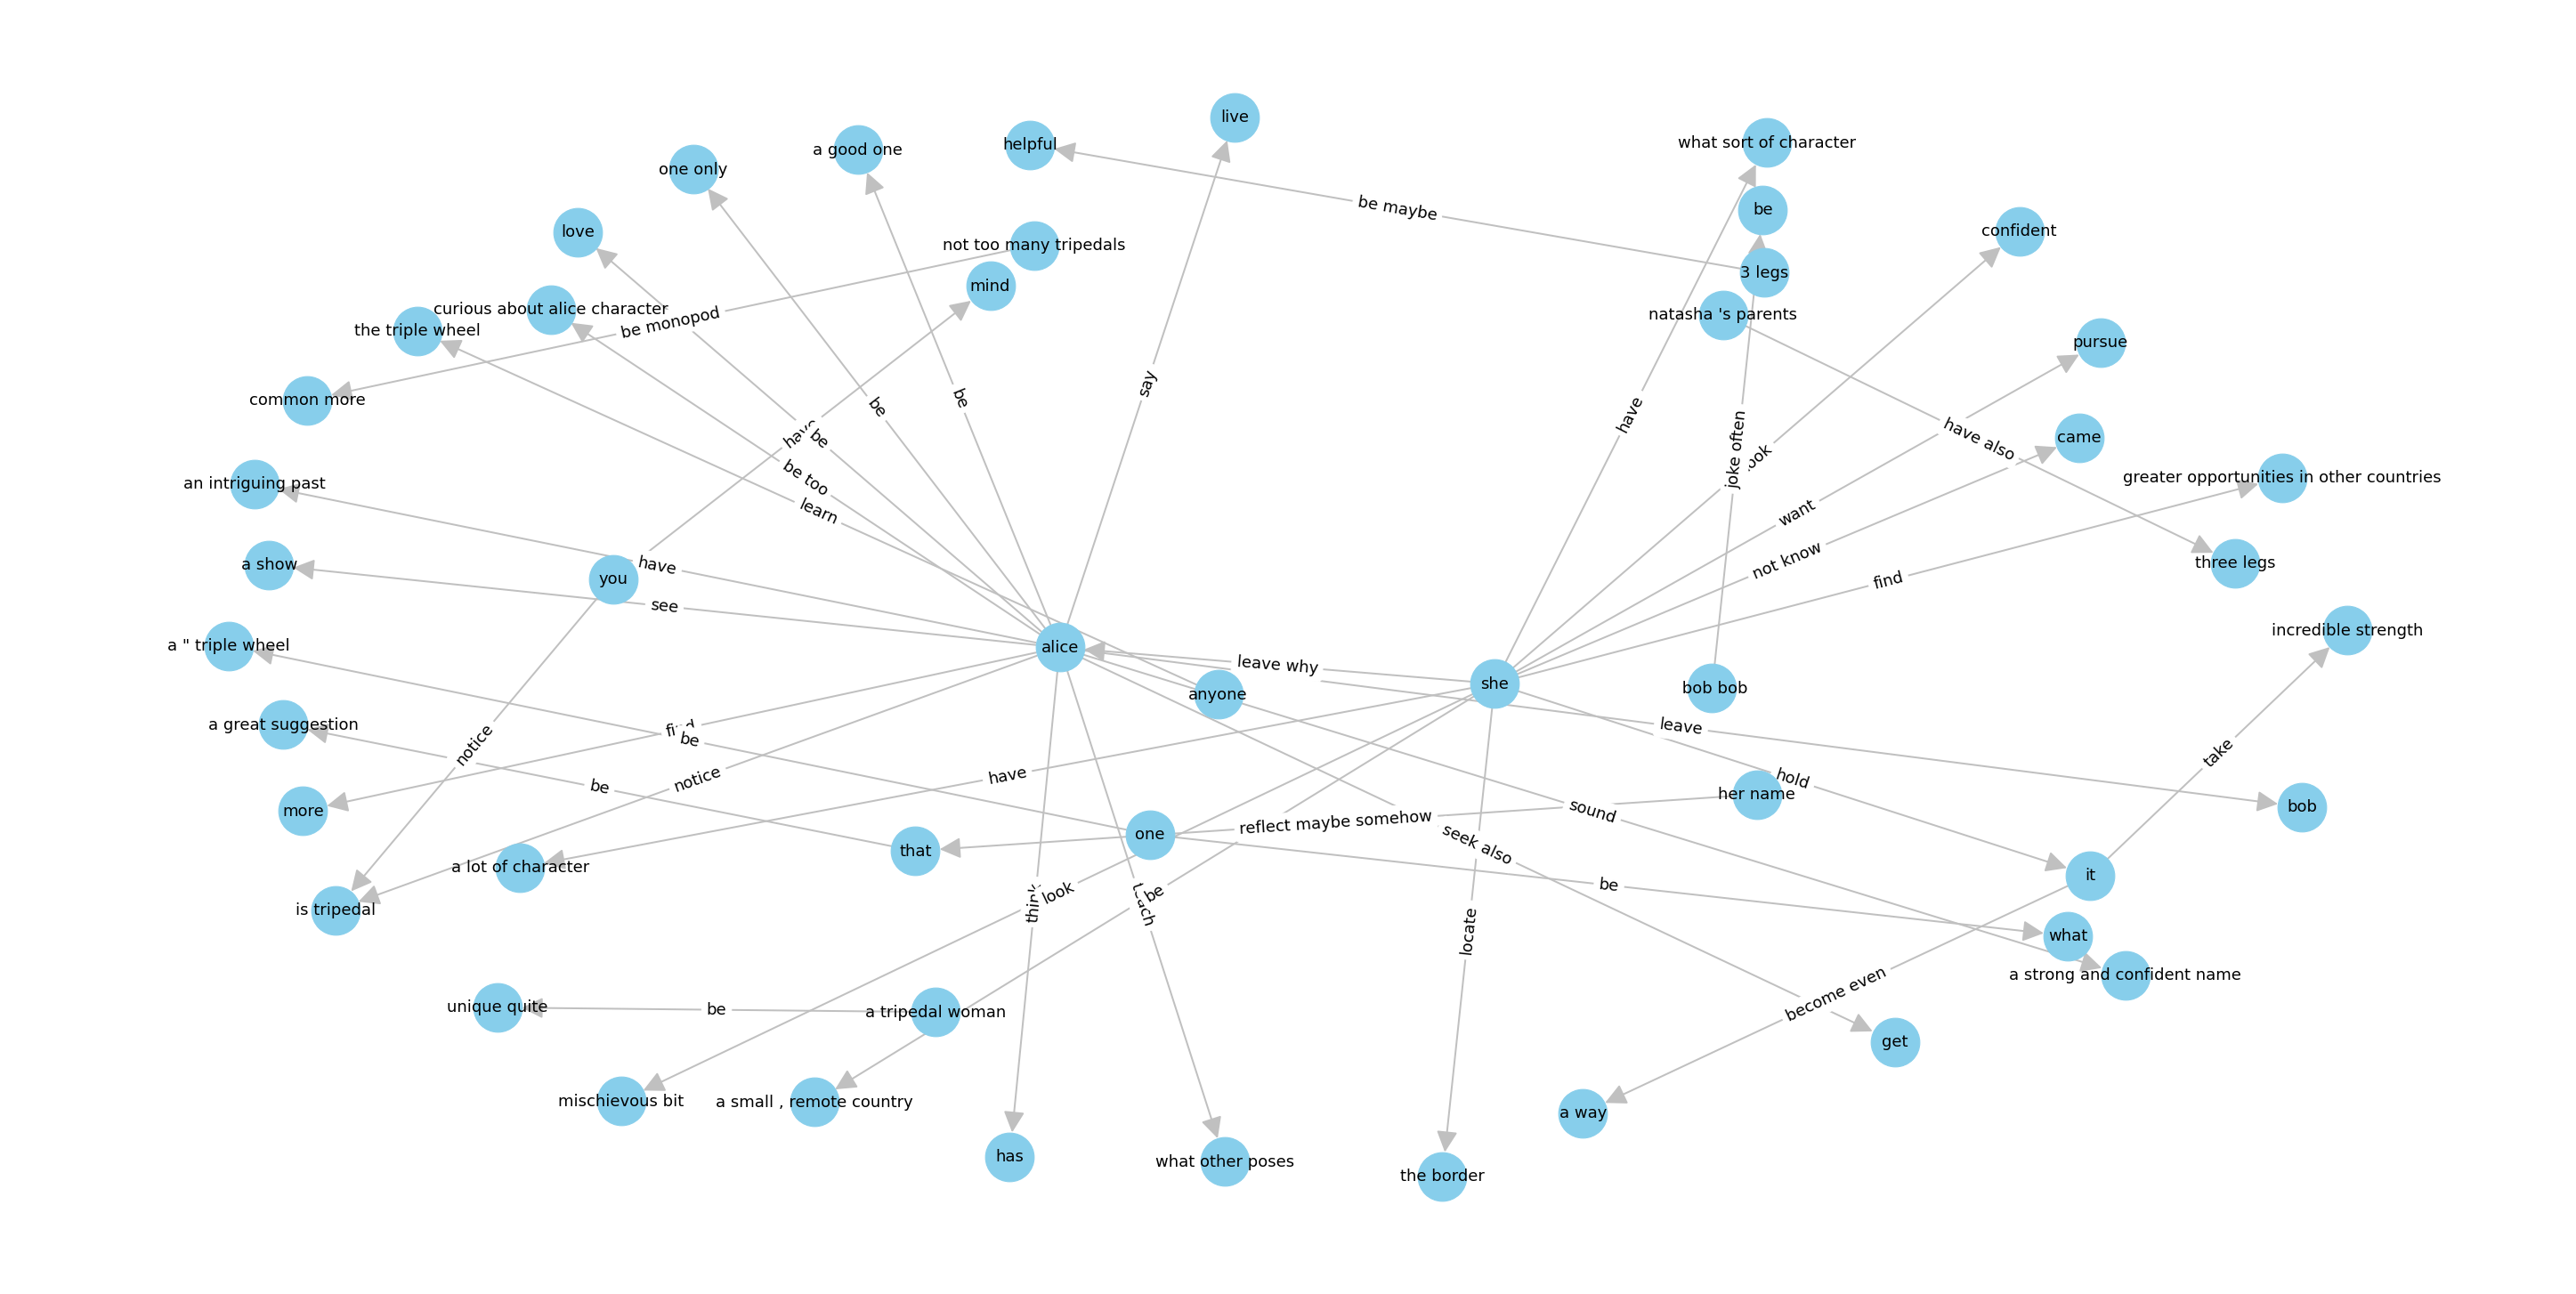

In [26]:
source = []
target = []
edge = []

for rel in relations:
    # extract subject
    source += [' '.join(i['left']) for i in rel]

    # extract object
    target += [' '.join(i['right']) for i in rel]

    # define edge
    edge += [i['rel'] for i in rel]


kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})

# create a directed-graph from a dataframe
Gpd=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          
Gpd_edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in Gpd.edges(data=True)])

show_fig(Gpd, Gpd_edge_labels, seed=1)

In [27]:
kg_df

,source,target,edge
0,you,is tripedal,notice
1,alice,is tripedal,notice
2,she,a lot of character,have
3,you,mind,have
4,alice,a good one,be
5,alice,a show,see
6,a tripedal woman,unique quite,be
7,she,what sort of character,have
8,alice,curious about alice character,be too
9,she,confident,look


In [28]:
# create a dict and save json
ser = json.dumps(nx.node_link_data(Gpd))
# print(ser)

In [29]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

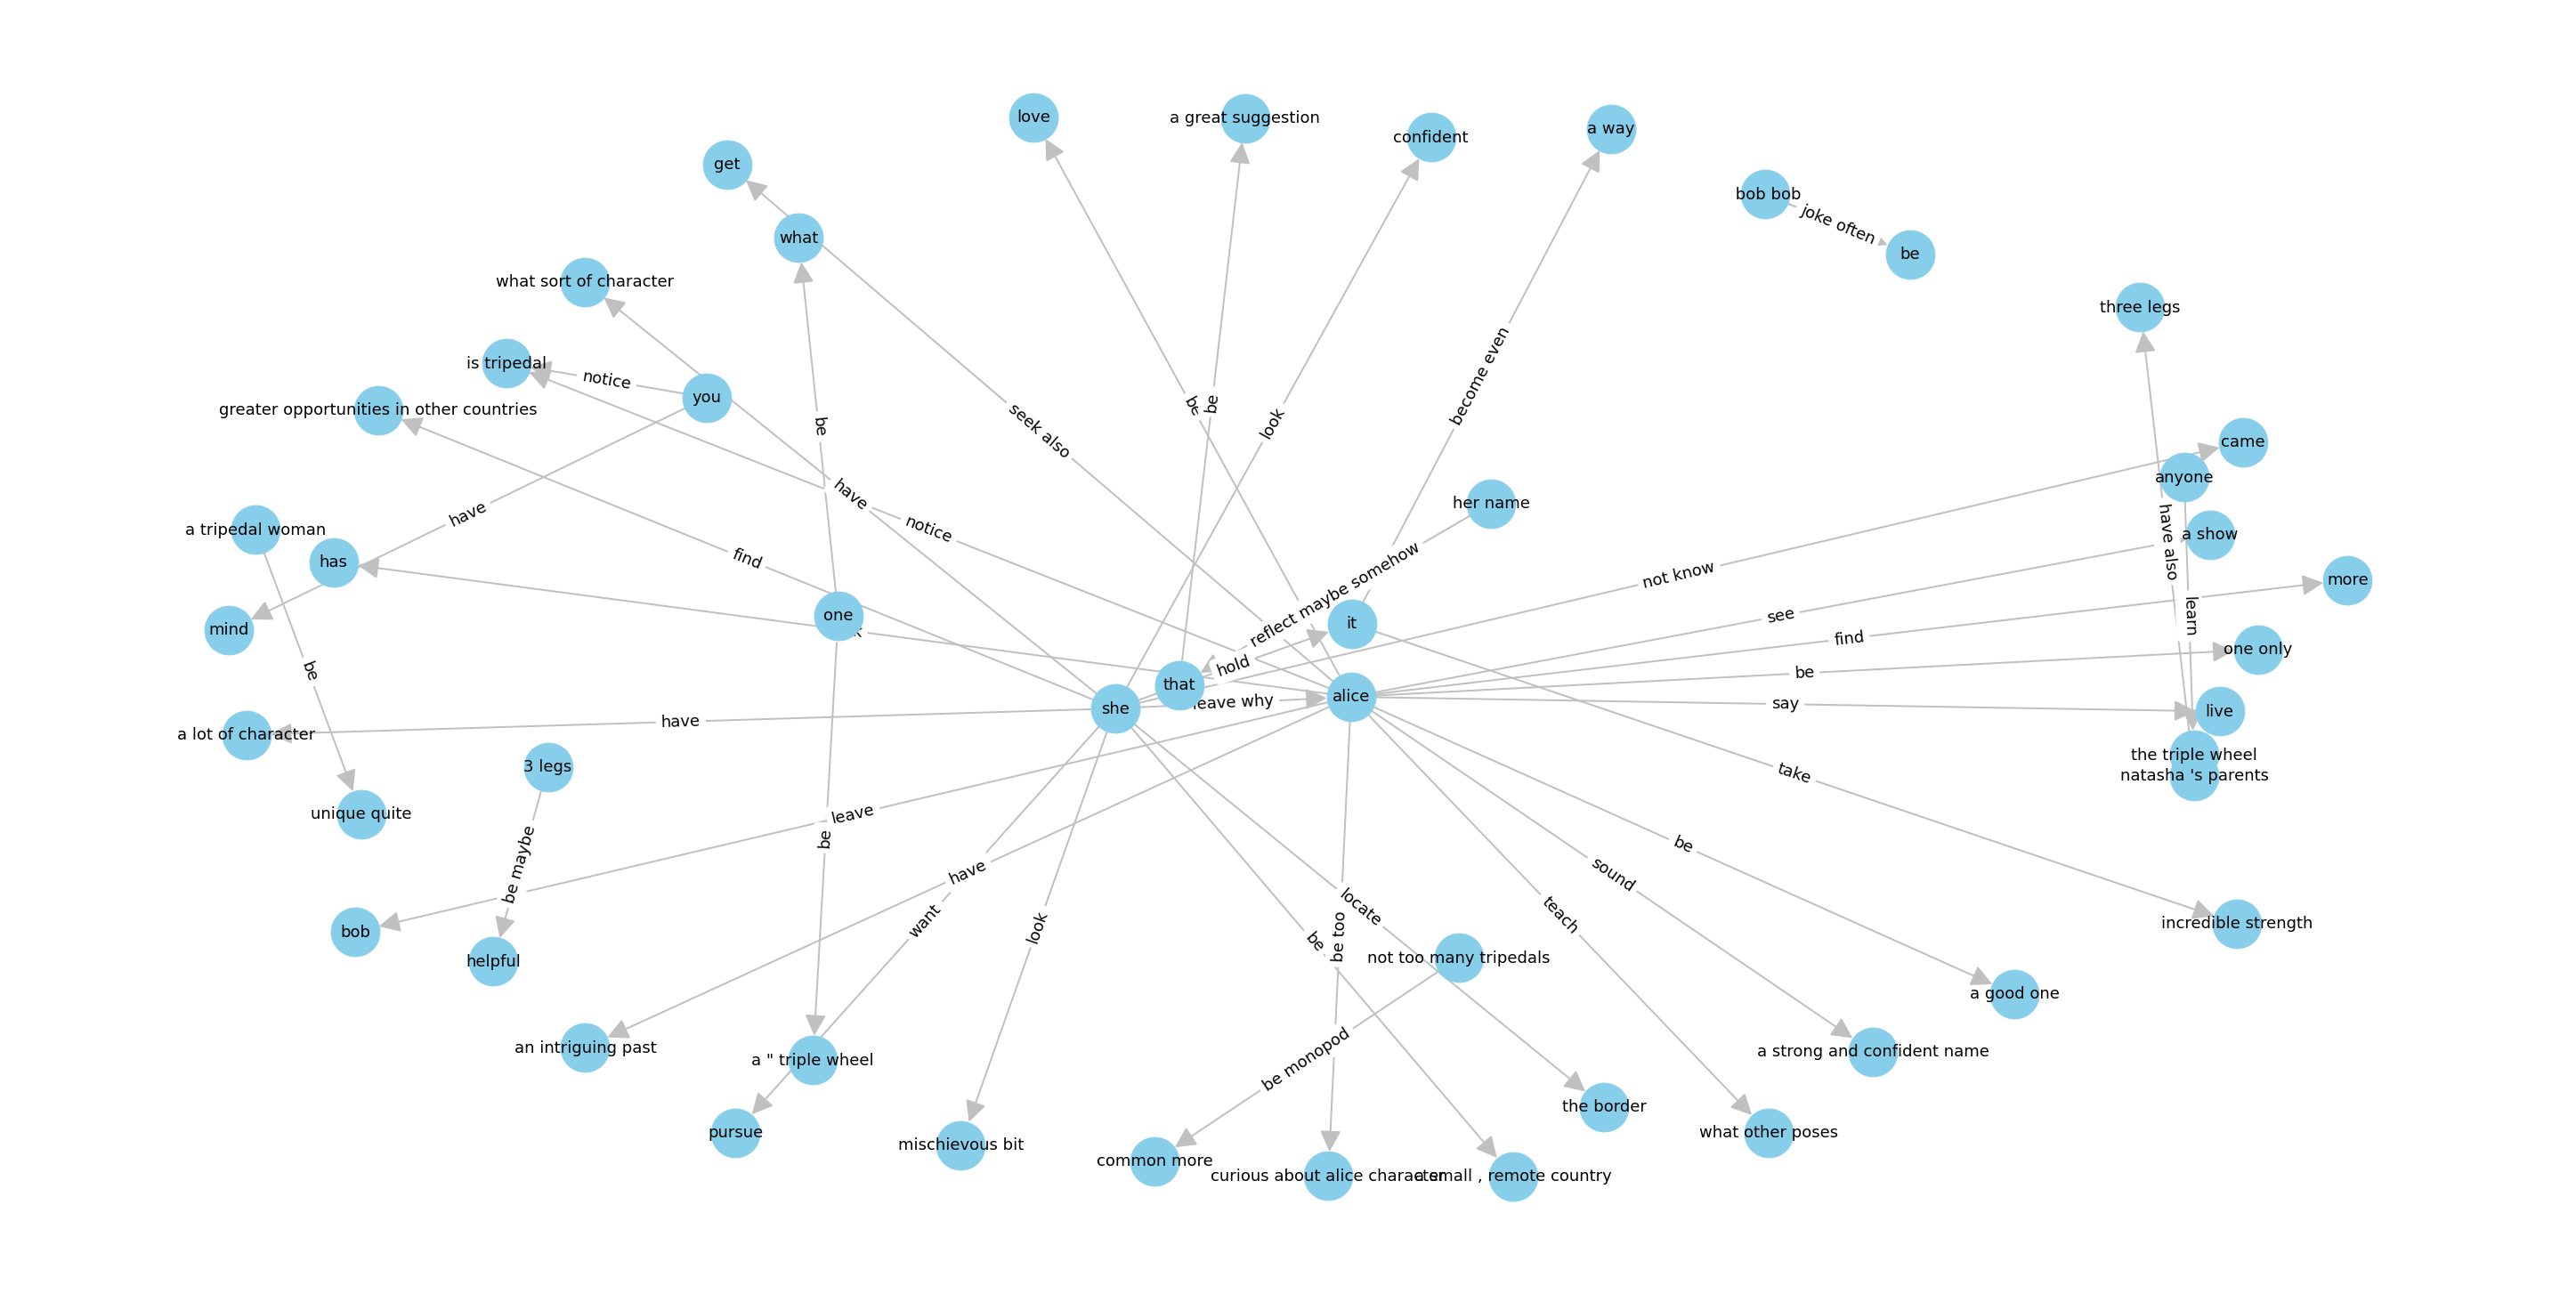

In [30]:
show_fig(G, edge_labels)

In [31]:
assert nx.node_link_data(G) == nx.node_link_data(Gpd)

In [32]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

In [33]:
assert jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges()) == (1.0, 1.0)

In [34]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
G.remove_node('alice')
G.add_node('something else')
G.add_edge('bill ted', 'something else', edge='agree')

edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

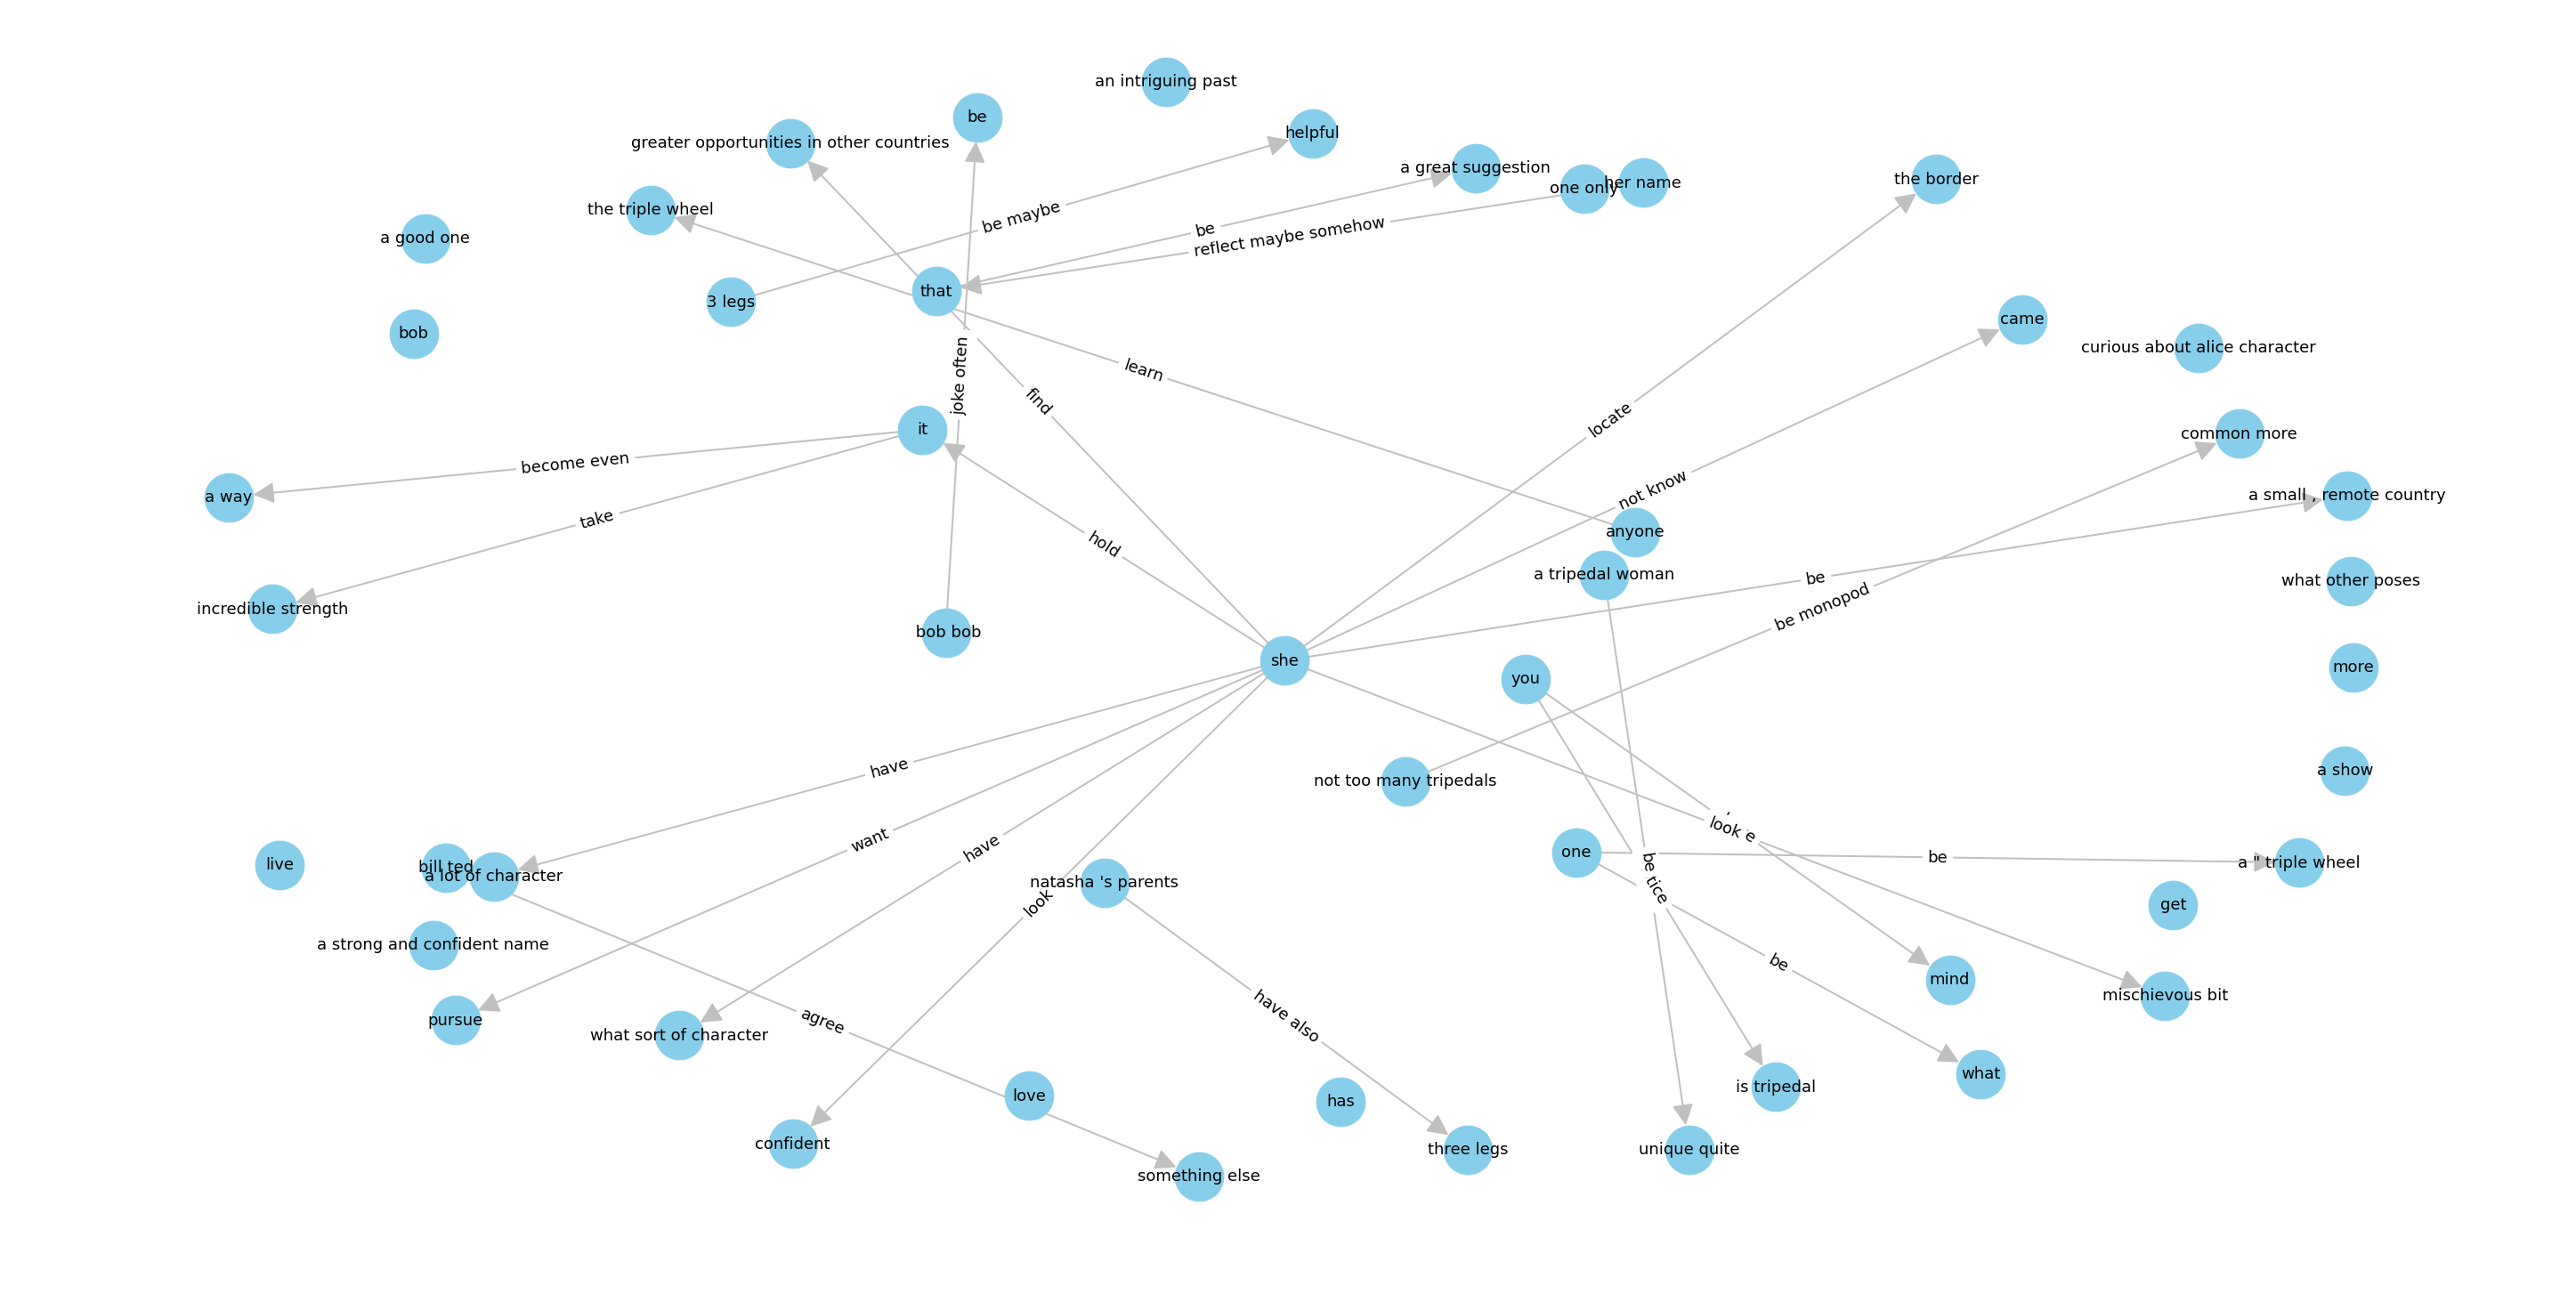

In [35]:
show_fig(G, edge_labels, seed=23)

In [36]:
jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges())

(0.94, 0.6)

In [37]:
a_not_b = set(Gpd.nodes()).difference(set(G.nodes()))
b_not_a = set(G.nodes()).difference(set(Gpd.nodes()))
a_not_b, b_not_a

({'alice'}, {'bill ted', 'something else'})

In [38]:
a_not_b = set(Gpd.edges()).difference(set(G.edges()))
for edge in a_not_b:
    print(edge[0], Gpd_edge_labels[edge], edge[1], sep=' | ')

alice | see | a show
alice | be | a good one
alice | leave | bob
alice | seek also | get
alice | sound | a strong and confident name
alice | have | an intriguing past
alice | be too | curious about alice character
alice | notice | is tripedal
alice | be | love
she | leave why | alice
alice | find | more
alice | teach | what other poses
alice | say | live
alice | think | has
alice | be | one only


In [39]:
b_not_a = set(G.edges()).difference(set(Gpd.edges()))
for edge in b_not_a:
    print(edge[0], edge_labels[edge], edge[1], sep=' | ')

bill ted | agree | something else


# Tests follow

In [ ]:
doc = nlp("It takes incredible strength and balance, but she can hold it for minutes at a time!")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['it'], 'rel': 'take', 'right': ['incredible strength']}, {'left': ['she'], 'rel': 'hold', 'right': ['it']}]

[{'left': ['it'], 'rel': 'take', 'right': ['incredible strength']}, {'left': ['she'], 'rel': 'hold', 'right': ['it']}]


In [ ]:
doc = nlp("Even when other kids his age had left to play professional football or basketball, Bill stayed dedicated to his passion for tennis and continued to practice hard every day.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['bill'], 'rel': 'stay', 'right': ['dedicated']}, {'left': ['bill'], 'rel': 'continue', 'right': ['practice']}]

Maximum recursion depth reached.
Maximum recursion depth reached.
[{'left': ['bill'], 'rel': 'stay', 'right': ['dedicated']}, {'left': ['bill'], 'rel': 'continue', 'right': ['practice']}]


In [ ]:
doc = nlp("It looks like she has a lot of character.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['she'], 'rel': 'have', 'right': ['a lot of character']}]

[{'left': ['she'], 'rel': 'have', 'right': ['a lot of character']}]


In [ ]:
doc = nlp("Hi Anna, did you notice that one of your women in the picture is tripedal?")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['you'], 'rel': 'notice', 'right': ['is tripedal']}]

[{'left': ['you'], 'rel': 'notice', 'right': ['is tripedal']}]


In [ ]:
doc = nlp("She looks confident and composed, but also a bit mischievous.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['she'], 'rel': 'look', 'right': ['confident']}, {'left': ['she'], 'rel': 'look', 'right': ['mischievous bit']}]

[{'left': ['she'], 'rel': 'look', 'right': ['confident']}, {'left': ['she'], 'rel': 'look', 'right': ['mischievous bit']}]


In [ ]:
doc = nlp("Rob was a programmer trying to solve an issue with his computer, but he wasn't sure how.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['rob'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]

[{'left': ['rob'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]


In [ ]:
doc = nlp("She looks confident and composed, but also a bit mischievous.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['she'], 'rel': 'look', 'right': ['confident']}, {'left': ['she'], 'rel': 'look', 'right': ['mischievous bit']}]

[{'left': ['she'], 'rel': 'look', 'right': ['confident']}, {'left': ['she'], 'rel': 'look', 'right': ['mischievous bit']}]


In [ ]:
doc = nlp("Rob was a programmer trying to solve an issue with his computer, but he wasn't sure how.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['rob'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]

[{'left': ['rob'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]


In [ ]:
doc = nlp(to_arch("Rob was a programmer trying to solve an issue with his computer, but he wasn't sure how."))
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['alice'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]

[{'left': ['alice'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]


In [ ]:
doc = nlp("She wanted to pursue She dream of becoming a yoga instructor and found greater opportunities in other countries .")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['she'], 'rel': 'want', 'right': ['pursue']}, {'left': ['she'], 'rel': 'find', 'right': ['greater opportunities in other countries']}]

[{'left': ['she'], 'rel': 'want', 'right': ['pursue']}, {'left': ['she'], 'rel': 'find', 'right': ['greater opportunities in other countries']}]


In [ ]:
doc = nlp("It takes incredible strength and balance, but she can hold it for minutes at a time!")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['it'], 'rel': 'take', 'right': ['incredible strength']}, {'left': ['she'], 'rel': 'hold', 'right': ['it']}]

[{'left': ['it'], 'rel': 'take', 'right': ['incredible strength']}, {'left': ['she'], 'rel': 'hold', 'right': ['it']}]


In [ ]:
doc = nlp("Anna agree with you that it doesn't sound particularly fun.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['anna'], 'rel': 'agree', 'right': ['you']}]

[{'left': ['anna'], 'rel': 'agree', 'right': ['you']}]


In [ ]:
doc = nlp("A tripedal woman is quite unique, even in the art world.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['a tripedal woman'], 'rel': 'be', 'right': ['unique quite']}]

[{'left': ['a tripedal woman'], 'rel': 'be', 'right': ['unique quite']}]


In [ ]:
# Note: doesn't identify Hackerfriendly as a person
doc = nlp("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['anna'], 'rel': 'discuss', 'right': ['the concept of emotional intelligence']}, {'left': ['anna'], 'rel': 'propose then', 'right': ['exploring']}]

[{'left': ['anna'], 'rel': 'discuss', 'right': ['the concept of emotional intelligence']}, {'left': ['anna'], 'rel': 'propose then', 'right': ['exploring']}]


In [ ]:
# ...but to_arch() does.
doc = nlp(to_arch("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications."))
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['alice', 'bob'], 'rel': 'discuss', 'right': ['the concept of emotional intelligence']}, {'left': ['alice'], 'rel': 'propose then', 'right': ['exploring']}]

[{'left': ['alice', 'bob'], 'rel': 'discuss', 'right': ['the concept of emotional intelligence']}, {'left': ['alice'], 'rel': 'propose then', 'right': ['exploring']}]


In [ ]:
doc = nlp("In desperation, he took it apart and managed to fix it himself.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['he'], 'rel': 'take apart', 'right': ['it']}, {'left': ['he'], 'rel': 'manage', 'right': ['fix']}]

[{'left': ['he'], 'rel': 'take apart', 'right': ['it']}, {'left': ['he'], 'rel': 'manage', 'right': ['fix']}]


In [ ]:
doc = nlp("That doesn't actually sound like fun, for the person stuck in VR with you.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['that'], 'rel': 'not sound actually', 'right': ['fun']}, {'left': ['the person'], 'rel': 'stick', 'right': ['you']}]

[{'left': ['that'], 'rel': 'not sound actually', 'right': ['fun']}, {'left': ['the person'], 'rel': 'stick', 'right': ['you']}]


In [ ]:
doc = nlp("Hackerfriendly was thinking about Bill, the tennis guy.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['hackerfriendly'], 'rel': 'think', 'right': ['the tennis guy']}]

[{'left': ['hackerfriendly'], 'rel': 'think', 'right': ['the tennis guy']}]


In [ ]:
doc = nlp("hackerfriendly was thinking about Bill, the tennis guy, and his buddy Charlie.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['hackerfriendly'], 'rel': 'think', 'right': ['bill', 'charlie', 'the tennis guy']}]

[{'left': ['hackerfriendly'], 'rel': 'think', 'right': ['bill', 'charlie', 'the tennis guy']}]


In [ ]:
doc = nlp("It's fascinating to think about the possibilities!")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['it'], 'rel': 'be', 'right': ['fascinating']}]

[{'left': ['it'], 'rel': 'be', 'right': ['fascinating']}]


In [ ]:
doc = nlp("Anna recalls was thinking about Bill, the tennis guy.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['anna'], 'rel': 'recall', 'right': ['thinking']}]

[{'left': ['anna'], 'rel': 'recall', 'right': ['thinking']}]


In [ ]:
doc = nlp("He was a programmer trying to solve an issue with his computer, but he wasn't sure how.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['he'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]

[{'left': ['he'], 'rel': 'be', 'right': ['trying']}, {'left': ['he'], 'rel': 'not be how', 'right': ['sure']}]


In [ ]:
doc = nlp("Even when other kids his age had left to play professional football or basketball, Bill stayed dedicated to his passion for tennis and continued to practice hard every day.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['bill'], 'rel': 'stay', 'right': ['dedicated']}, {'left': ['bill'], 'rel': 'continue', 'right': ['practice']}]

Maximum recursion depth reached.
Maximum recursion depth reached.
[{'left': ['bill'], 'rel': 'stay', 'right': ['dedicated']}, {'left': ['bill'], 'rel': 'continue', 'right': ['practice']}]


In [ ]:
doc = nlp("He started playing at the age of 8.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['he'], 'rel': 'start', 'right': ['playing at the age of 8']}]

[{'left': ['he'], 'rel': 'start', 'right': ['playing at the age of 8']}]


In [ ]:
doc = nlp("He didn't start playing at the age of 8 but quickly became known as one of the best players in town.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['he'], 'rel': 'not start', 'right': ['playing']}]

[{'left': ['he'], 'rel': 'not start', 'right': ['playing']}]


In [ ]:
doc = nlp("Anna and Ricky and their friend's cousin's dog Phil discussed the work of Erving Goffman and the commonalities between various activities.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['anna', 'phil', 'ricky'], 'rel': 'discuss', 'right': ['the work']}]

[{'left': ['anna', 'phil', 'ricky'], 'rel': 'discuss', 'right': ['the work']}]


In [ ]:
doc = nlp("Anna and Ricky and their friend Jim's cousin's butler, Phil, discussed the work of Erving Goffman and the commonalities between various activities.")
rel = get_relationships(doc, False)
print(rel)
assert rel == [{'left': ['anna', 'phil', 'ricky'], 'rel': 'discuss', 'right': ['the work']}]

[{'left': ['anna', 'phil', 'ricky'], 'rel': 'discuss', 'right': ['the work']}]


In [72]:
doc = nlp_coref("hackerfriendly was thinking about Bill, the tennis guy, and his buddy Charlie.")
displacy.render(doc, "ent")

In [ ]:
speaker = Span(doc, 0, 1, label="PERSON")
doc.set_ents([speaker], default="unmodified")
print([(e.text, e.start, e.end, e.label_) for e in doc.ents])

In [ ]:
displacy.render(doc, "ent")

In [ ]:
displacy.render(doc)

In [ ]:
tok = doc[0]
tok

In [ ]:
tok.tag_, tok.dep_

In [ ]:
assert get_relationships("mfkje lfkj kajhkljhdkjh") == []

In [ ]:
rel = get_relationships("No, Anna be not describing heavenbanning. ", False)
print(rel)
assert rel == [{'left': ['anna'], 'rel': 'not describe', 'right': ['heavenbanning']}]

In [ ]:
to_arch("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.")

In [ ]:
ts = "Anna and Hackerfriendly talked to Phil, and Anna mentioned Erving Goffman's sister Edith. Hackerfriendly thought it was funny, and so did Phil."

displacy.render(nlp(ts))
displacy.render(nlp(to_arch(ts)))

In [ ]:
for a in archetypes + ['hackerfriendly']:
    print(a, nlp_coref(a)[0].pos_)